<a href="https://colab.research.google.com/github/victoriaprestes/ifood-data-analyst-case/blob/main/iFood_Data_Analyst_Case_An_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o dataset


In [884]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from scipy.stats.mstats import winsorize

In [885]:
project_data = pd.read_csv('project_data.csv')
# Para não mexer no original, vou criar uma cópia do dataframe
ifood_df = project_data.copy()
#Verificando meus dados
ifood_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Lidando com nulos e outliers


In [886]:
# Via de regra, se os nulos forem até 5% dos dados, podemos simplesmente deletá-los.
lim = len(ifood_df) * 0.05
to_drop = ifood_df.columns[(ifood_df.isna().sum() < lim) & (ifood_df.isna().sum() > 0)]
ifood_df.dropna(subset=to_drop, inplace=True)
ifood_df['Income'].isna().sum()

0

In [887]:
ifood_df['Income'].describe()

,Income
count,2216.000000
mean,52247.251354
std,25173.076661
min,1730.000000
25%,35303.000000
50%,51381.500000
75%,68522.000000
max,666666.000000


Aqui já encontro outro problema: os valores máximo e mínimos diferem muito do esperado, claramente outliers.
Consequentemente, usar a média está fora de questão, visto que ela é altamente influenciada por esses valores.



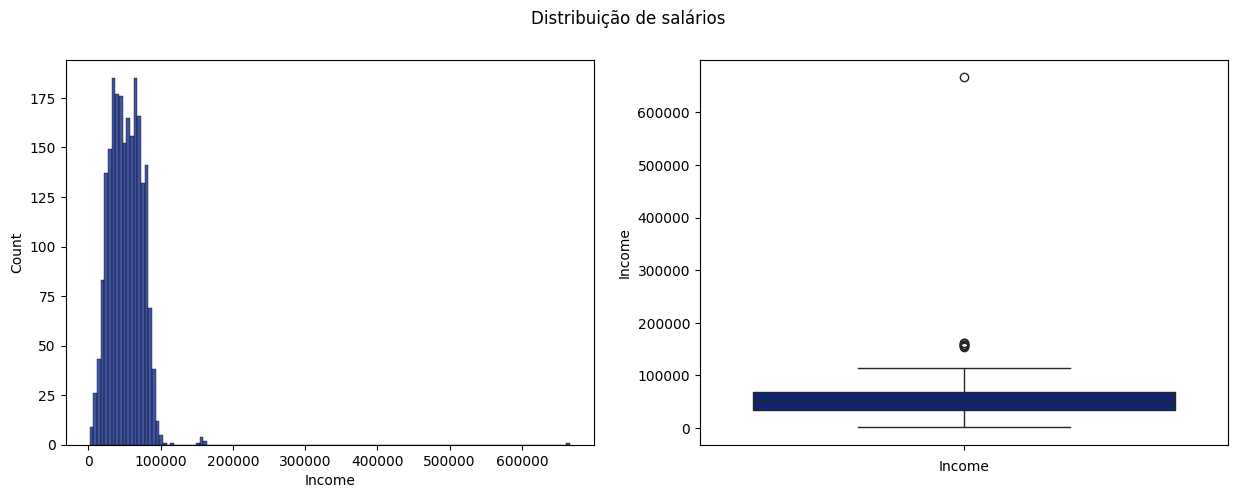

In [888]:
#Verificando a distribuição dos dados
sns.set_palette('dark')
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=ifood_df, x='Income',fill=True, ax=ax[0])
sns.boxplot(data=ifood_df['Income'],  ax=ax[1])
plt.xlabel('Income')
plt.suptitle('Distribuição de salários')
plt.show()

In [889]:
def upper_limits(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3-q1
    limit = 1.5 * iqr
    upper = q3+limit
    return upper

upper = upper_limits(ifood_df, 'Income')
print('Limite superior: ', upper)


Limite superior:  118350.5


In [890]:
#Imputando todos os outliers para o valor do limite superior
ifood_df['Income'] = [upper if x > upper else x for x in ifood_df['Income']]
print(ifood_df['Income'].nlargest())

164     118350.5
617     118350.5
655     118350.5
687     118350.5
1300    118350.5
Name: Income, dtype: float64


In [891]:
# Data em que se inscreveu > anos que é cliente
ifood_df['Dt_Customer'] = pd.to_datetime(ifood_df['Dt_Customer']).dt.year
ifood_df['CustomerYears'] = datetime.now().year - ifood_df['Dt_Customer']
ifood_df['CustomerYears'].astype('int')
ifood_df.drop(columns='Dt_Customer', axis=1, inplace=True)


In [892]:
#Trocando ano de nascimento por idade
ifood_df['CustomerAge'] = pd.Timestamp('now').year - ifood_df['Year_Birth']
ifood_df.drop(columns='Year_Birth', axis=1, inplace=True)

#Verificando se tenho valores errados e/ou outliers
largest = ifood_df['CustomerAge'].nlargest()
smallest = ifood_df['CustomerAge'].nsmallest()

print(largest, smallest)

239     131
339     125
192     124
1950     84
424      83
Name: CustomerAge, dtype: int64 46      28
1170    28
696     29
747     29
995     29
Name: CustomerAge, dtype: int64


In [893]:
#Deletando os valores acima de 100
ifood_df.drop(index=ifood_df[ifood_df['CustomerAge'] >= 100].index, inplace=True)
ifood_df['CustomerAge'].nlargest()


,CustomerAge
1950,84
424,83
39,81
358,81
415,81


In [894]:
#Verificando tipos
ifood_df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [895]:
 # Substituindo valores desnecessários para melhorar a interpretação
ifood_df['Marital_Status'] = ifood_df['Marital_Status'].replace(['Alone'],'Single')
ifood_df['Marital_Status'] = ifood_df['Marital_Status'].replace('Together', 'Married')
ifood_df.drop(index=ifood_df[ifood_df['Marital_Status'] == 'Absurd'].index, inplace=True)
ifood_df.drop(index=ifood_df[ifood_df['Marital_Status'] == 'YOLO'].index, inplace=True)
ifood_df['Marital_Status'].unique()

array(['Single', 'Married', 'Divorced', 'Widow'], dtype=object)

In [896]:
# Vinhos, frutas, carnes e peixes são produtos regulares
ifood_df['MntRegularProds'] = ifood_df[['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts']].sum(axis=1)
ifood_df.drop(columns=['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts'], axis=1, inplace=True)

In [897]:
ifood_df['NumChildren'] = ifood_df[['Kidhome', 'Teenhome']].sum(axis=1)
ifood_df.drop(columns=['Kidhome', 'Teenhome'], inplace=True)
ifood_df['NumChildren'].value_counts()

,count
NumChildren,
1,1113
0,630
2,416
3,50


In [898]:
# Tipos corretos de cada coluna
for column in ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']:
  ifood_df[column] = ifood_df[column].astype('bool')


Por último, vou checar duplicatas

In [899]:
duplicated_vals =  ifood_df.duplicated(keep='last')
print('Número de duplicatas: ', duplicated_vals.sum())

Número de duplicatas:  0


In [900]:
#Mudando a ordem das colunas pra facilitar a leitura
ifood_df = ifood_df[['ID','Education', 'Marital_Status', 'Income','NumChildren', 'CustomerAge', 'CustomerYears',
       'Recency','Complain', 'Response', 'AcceptedCmp1', 'AcceptedCmp2',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',  'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'MntRegularProds', 'MntGoldProds','Z_CostContact', 'Z_Revenue']]
ifood_df.head(3)

,ID,Education,Marital_Status,Income,NumChildren,CustomerAge,CustomerYears,Recency,Complain,Response,...,AcceptedCmp5,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,MntRegularProds,MntGoldProds,Z_CostContact,Z_Revenue
0,5524,Graduation,Single,58138.0,0,67,12,58,False,True,...,False,3,8,10,4,7,1529,88,3,11
1,2174,Graduation,Single,46344.0,2,70,10,38,False,False,...,False,2,1,1,2,5,21,6,3,11
2,4141,Graduation,Married,71613.0,0,59,11,26,False,False,...,False,1,8,2,10,4,734,42,3,11


# Visualizando distribuições



*   A média salarial está na faixa de 50 mil;
* Os valor gasto com os dois tipos de produtos tem uma distribuição positiva (enviesada para a direita, valores mais baixos mais comuns), com os produtos regulares tendo uma quantidade maior de vendas.
*   No geral, a maior parte dos entrevistados fez até cinco compras nos últimos 2 anos (ofertas, web, catálogo e loja);
* A maioria dos entrevistados está na faixa 45 - 55 anos;

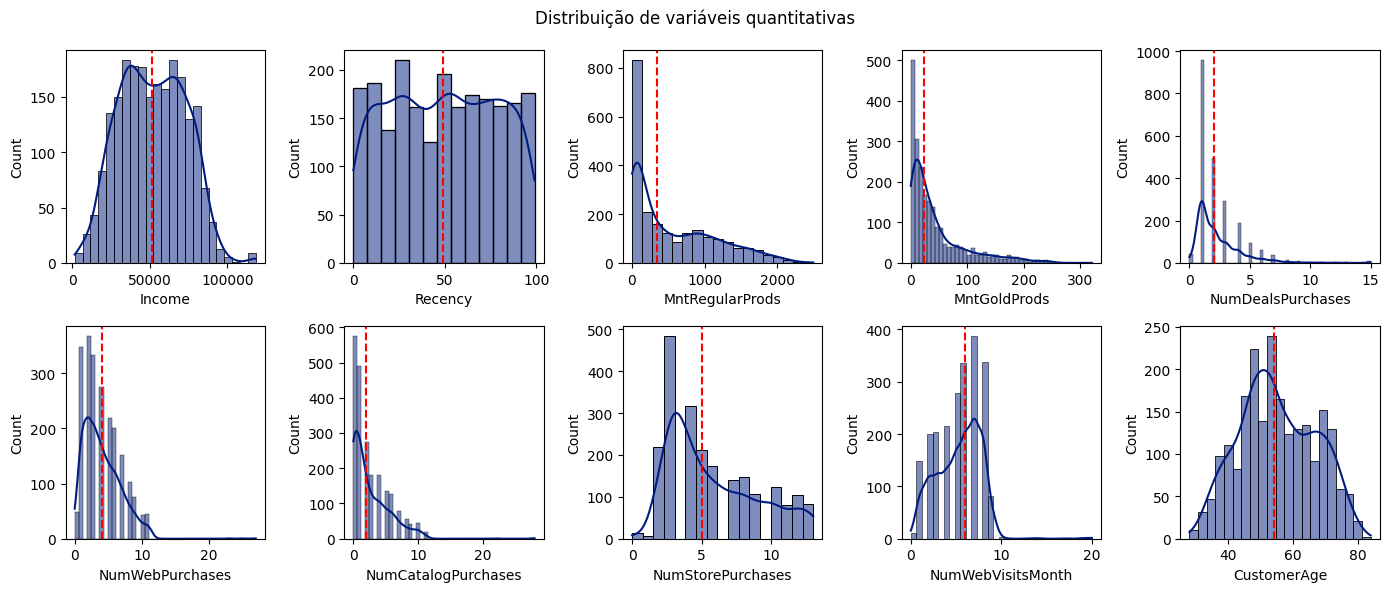

In [901]:
# Criando histogramas das colunas quantitativas com a linha da mediana em vermelho
#
numeric = ifood_df[['Income', 'Recency', 'MntRegularProds', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'CustomerAge']]

fig, ax = plt.subplots(2,5, figsize=(14, 6))
ax = ax.flatten()
for i,col in enumerate(numeric.columns):
      sns.histplot(data=ifood_df, x=col,kde=True, ax=ax[i])
      ax[i].axvline(ifood_df[col].median(), color='red', linestyle='--')
plt.suptitle('Distribuição de variáveis quantitativas')
plt.tight_layout()
plt.show()


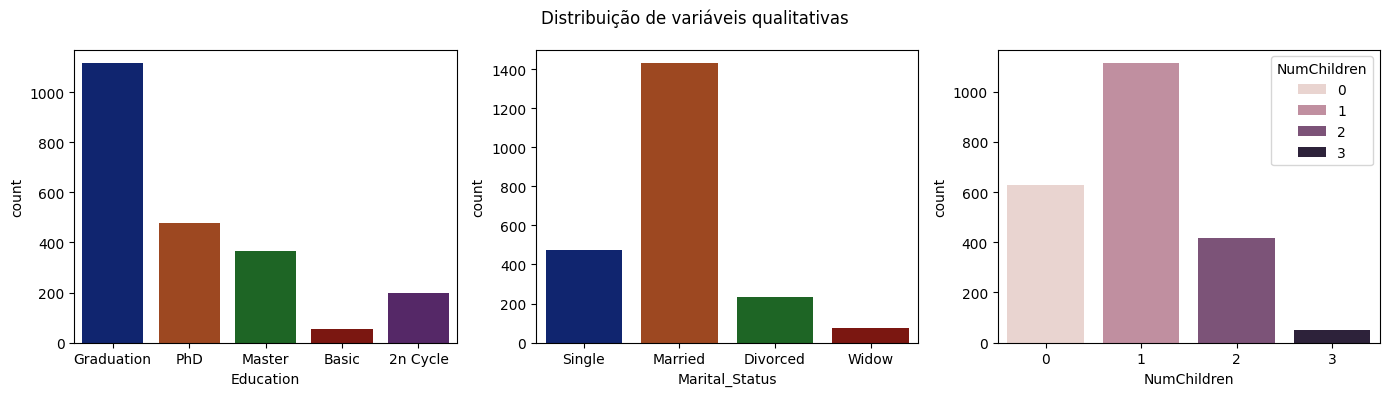

In [902]:
# Variáveis categóricas qualitativas

fig, ax = plt.subplots(1,3, figsize=[14,4])
for i, col in enumerate(['Education', 'Marital_Status', 'NumChildren']):
  sns.countplot(data=ifood_df, x=col, ax=ax[i], hue=col)
plt.suptitle('Distribuição de variáveis qualitativas')
plt.tight_layout()
plt.show()


## Verificando Correlação

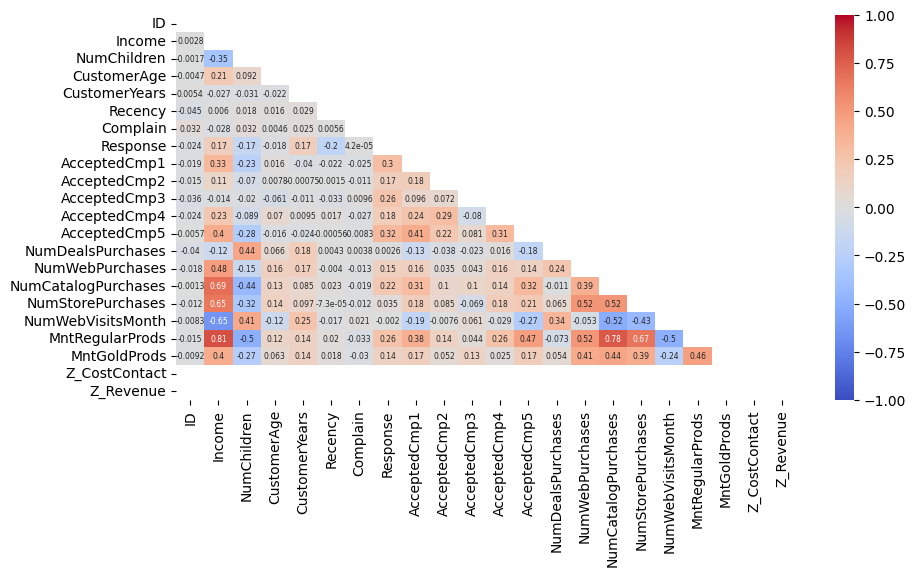

In [903]:
mask = np.triu(np.ones_like(ifood_df.corr(numeric_only=True)))
plt.figure(figsize=(10, 5))
sns.heatmap(ifood_df.corr(numeric_only=True), cmap='coolwarm', center=0, vmin=-1, vmax=1,
                      annot=True, mask=mask, annot_kws={'size': 5.5})
plt.show()

No geral, as únicas correlações relevantes são entre MntRegularProds x TotalPurchases e MntRegularProds x Income. Vamos olhar mais a fundo

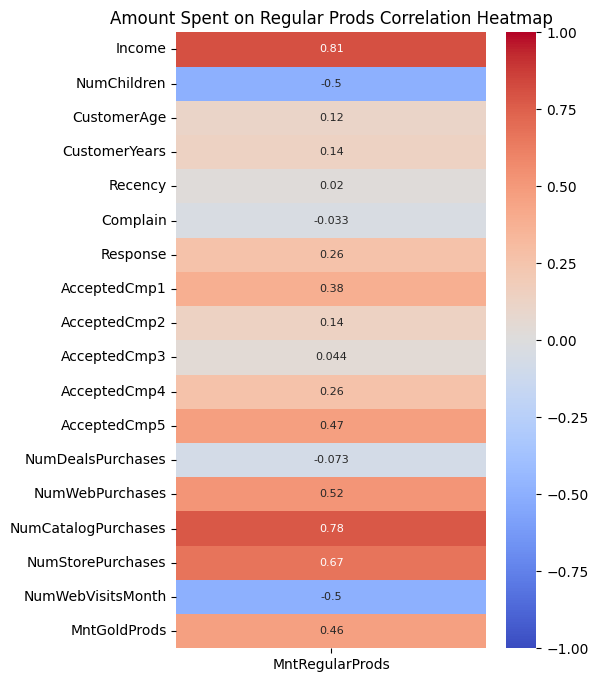

In [904]:
income_corr = ifood_df.corr(numeric_only=True)['MntRegularProds'].to_frame().drop(['ID','Z_CostContact', 'Z_Revenue', 'MntRegularProds'])
plt.figure(figsize=(5, 8))
sns.heatmap(income_corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            annot=True, annot_kws={'size': 8})
plt.title("Amount Spent on Regular Prods Correlation Heatmap")
plt.show()

Analisando o mapa de calor, vemos que o tanto gasto em produtos regulares está fortemente correlacionado ao tanto de compras feitas diretamente pelo catálogo e levemente correlacionado ao tanto de compras feitas pela loja. Além disso, a maior correlação está com o salário anual, indicando que quanto maior o salário, maior o gasto nesses produtos.

In [905]:
# Quero ver quanto foi gasto em cada categoria de produtos, separado pelos  diferentes canais de venda.

def calculate_total_spent(df, product_col, channel_col):
  return (df[product_col] * df[channel_col]).sum()

product_cols = ['MntRegularProds', 'MntGoldProds']
channel_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

results = {}

for product_col in product_cols:
  results[product_col] = {}

  for channel_col in channel_cols:
    results[product_col][channel_col] = calculate_total_spent(ifood_df, product_col, channel_col)


spending_by_channel = pd.DataFrame(results).T

spending_by_channel.columns = ['Web', 'Catalog', 'Store']


spending_by_channel

,Web,Catalog,Store
MntRegularProds,6887133,6209577,10000607
MntGoldProds,523068,404126,706228


In [906]:
# Criando as novas colunas
ifood_df['high_income'] = ifood_df['Income'] >= 70000
ifood_df['medium_income'] = (ifood_df['Income'] > 30000) & (ifood_df['Income'] < 70000)
ifood_df['low_income'] = ifood_df['Income'] <= 30000



In [909]:
# Como pretendo comparar várias métricas com salário, o código vai ficar muito longo e confuso, então pra facilitar a leitura, vou criar algumas funções.


def high_income_melt(value_vars, var_name, value_name):
  # Cria uma tabela em que 'high_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(ifood_df, id_vars=['high_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['high_income'] == True]

def medium_income_melt(value_vars, var_name, value_name):
 # Cria uma tabela em que 'medium_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(ifood_df, id_vars=['medium_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['medium_income'] == True]

def low_income_melt(value_vars, var_name, value_name):
 # Cria uma tabela em que 'low_income' é o ID com tipo de produto e valor como colunas
  melted = pd.melt(ifood_df, id_vars=['low_income'], value_vars=value_vars, var_name=var_name, value_name=value_name)
  return melted[melted['low_income'] == True]


def plot_income(x_col, y_col, df_list, hue_col, *args, **kwargs):
# Cria uma figura com o gráfico de barras de cada intervalo salarial.
  fig, ax = plt.subplots(1,3, **kwargs, sharey=True)
  titles = ['High Income', 'Medium Income', 'Low Income']
  for i, df in enumerate(df_list):
    sns.barplot(x=x_col, y=y_col, data=df, hue=hue_col, ax=ax[i], estimator=sum)
    ax[i].set_title(titles[i])
  plt.suptitle(*args)
  plt.tight_layout()
  plt.show()




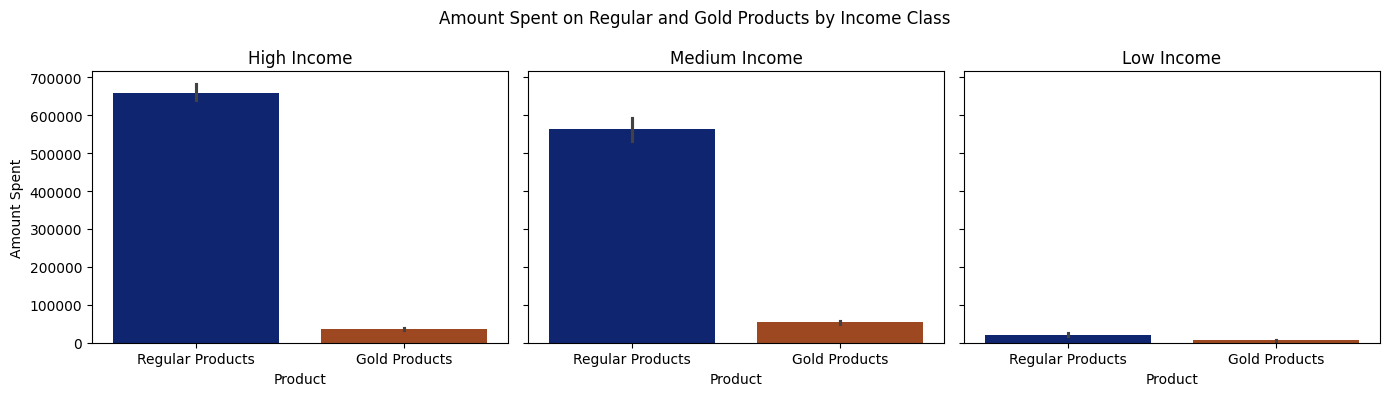

In [910]:
# Separando as classes de salário por quantidade gasta em cada produto
high_income_mnt = high_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Product', value_name='Amount Spent')
medium_income_mnt = medium_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Product', value_name='Amount Spent')
low_income_mnt = low_income_melt(value_vars=['MntRegularProds', 'MntGoldProds'], var_name='Product', value_name='Amount Spent')

#Mudando o nome das variáveis
high_income_mnt['Product'] = high_income_mnt['Product'].replace({'MntRegularProds': 'Regular Products', 'MntGoldProds': 'Gold Products'})
medium_income_mnt['Product'] = medium_income_mnt['Product'].replace({'MntRegularProds': 'Regular Products', 'MntGoldProds': 'Gold Products'})
low_income_mnt['Product'] = low_income_mnt['Product'].replace({'MntRegularProds': 'Regular Products', 'MntGoldProds': 'Gold Products'})

plot_income('Product', 'Amount Spent', [high_income_mnt, medium_income_mnt, low_income_mnt], 'Product', 'Amount Spent on Regular and Gold Products by Income Class', figsize=(14,4))

Como esperado, os clientes que ganham mais também gastam mais. Porém, os clientes de salário médio são os que gastam mais com produtos ouro.

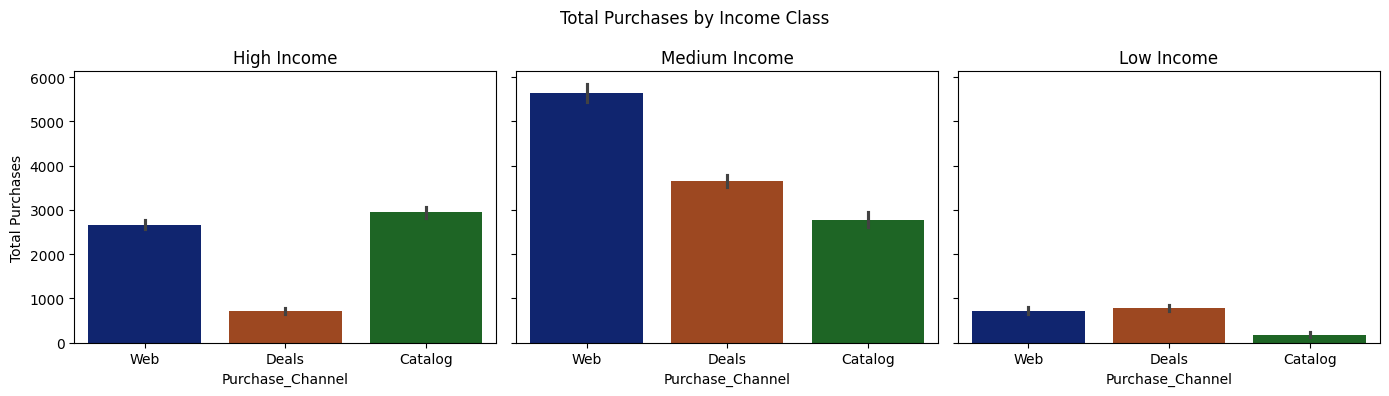

In [911]:
# Separando as classes de salário por local de compra
high_income_purchases = high_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases'], var_name='Purchase_Channel', value_name='Total Purchases')
medium_income_purchases = medium_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases'], var_name='Purchase_Channel', value_name='Total Purchases')
low_income_purchases = low_income_melt(value_vars=['NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases'], var_name='Purchase_Channel', value_name='Total Purchases')
#Mudando o nome das variáveis
high_income_purchases['Purchase_Channel'] = high_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web', 'NumDealsPurchases': 'Deals', 'NumCatalogPurchases':'Catalog'})
medium_income_purchases['Purchase_Channel'] = medium_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web', 'NumDealsPurchases': 'Deals', 'NumCatalogPurchases':'Catalog'})
low_income_purchases['Purchase_Channel'] = low_income_purchases['Purchase_Channel'].replace({'NumWebPurchases':'Web', 'NumDealsPurchases': 'Deals', 'NumCatalogPurchases':'Catalog'})

plot_income('Purchase_Channel', 'Total Purchases', [high_income_purchases, medium_income_purchases, low_income_purchases], 'Purchase_Channel', 'Total Purchases by Income Class', figsize=(14,4))


Clientes com salários maiores compram primariamente no catálogo,

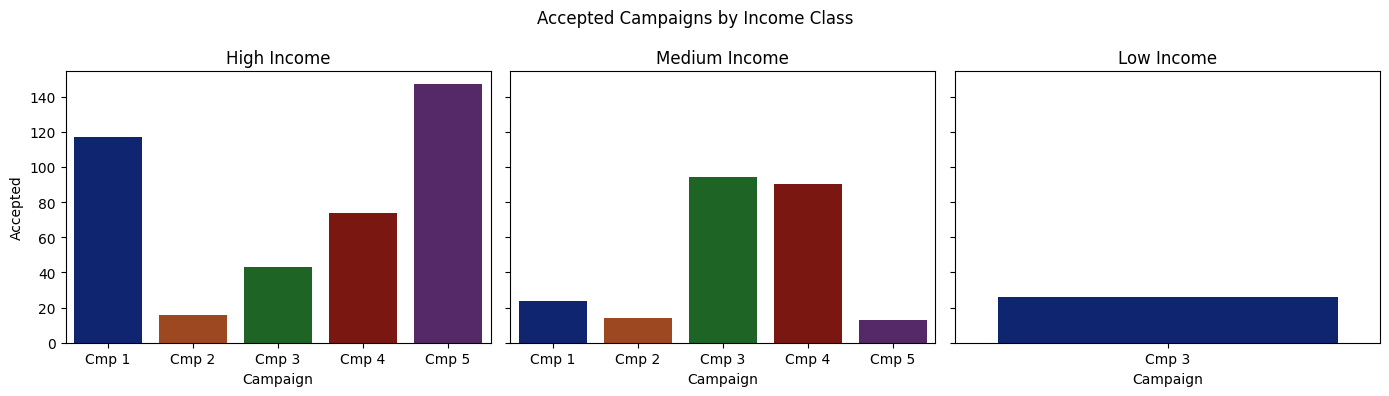

In [913]:
# Separando as classes de salário por aceitação de campanhas
high_income_acceptance = high_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
medium_income_acceptance = medium_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
low_income_acceptance = low_income_melt(value_vars=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], var_name='Campaign', value_name='Accepted')
#Mudando o nome das variáveis
high_income_acceptance['Campaign'] = high_income_acceptance['Campaign'].replace({'AcceptedCmp1': 'Cmp 1', 'AcceptedCmp2': 'Cmp 2', 'AcceptedCmp3': 'Cmp 3', 'AcceptedCmp4': 'Cmp 4', 'AcceptedCmp5': 'Cmp 5'})
medium_income_acceptance['Campaign'] = medium_income_acceptance['Campaign'].replace({'AcceptedCmp1': 'Cmp 1', 'AcceptedCmp2': 'Cmp 2', 'AcceptedCmp3': 'Cmp 3', 'AcceptedCmp4': 'Cmp 4', 'AcceptedCmp5': 'Cmp 5'})
low_income_acceptance['Campaign'] = low_income_acceptance['Campaign'].replace({'AcceptedCmp1': 'Cmp 1', 'AcceptedCmp2': 'Cmp 2', 'AcceptedCmp3': 'Cmp 3', 'AcceptedCmp4': 'Cmp 4', 'AcceptedCmp5': 'Cmp 5'})
# Filtrando somente as campanhas aceitas
high_income_acceptance = high_income_acceptance[high_income_acceptance['Accepted'] == True]
medium_income_acceptance = medium_income_acceptance[medium_income_acceptance['Accepted'] == True]
low_income_acceptance = low_income_acceptance[low_income_acceptance['Accepted'] == True]

plot_income('Campaign', 'Accepted', [high_income_acceptance, medium_income_acceptance, low_income_acceptance], 'Campaign', 'Accepted Campaigns by Income Class', figsize=(14,4))

cliente vip (gastam mais)
* Valor alto: >= 2000
* Valor baixo <= 500

cliente gold (gastam com prod caro)
* alto: >= 300
* baixo: <= 40

cliente pechincha
* alto: >=10
* baixo: <=10

(ver como cada tipo de cliente compra e se aceitou campanhas)


quant de visitas tem a ver com compras web?